In [1]:
import sys
!{sys.executable} -m pip install google-cloud-core
!{sys.executable} -m pip install google-cloud-storage

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from google.cloud import storage
from tempfile import TemporaryFile
import json

In [3]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/shuang/Zalando-code/octopus_google_credentials.json"

In [4]:
def get_data_frame(path_gs):
    """
    Download all files from GS located at specified path
    and create a pandas data frame
    Args:
        data_ref(RemoteFileReference): reference to a file in cloud storage. Bucket + key
    """
    client = storage.client.Client(project = "team-octopus")
    bucket = client.get_bucket("analysis-exports")
    blobs = bucket.list_blobs(prefix = path_gs)
    blobs = list(blobs) # TypeError: object of type 'HTTPIterator' has no len()
    num_blobs = len(blobs)
    print("csv file is in {} blobs, with blob sizes: {}".format(num_blobs, [blob.size for blob in blobs]))
    data_frames = []
    for blob in blobs:
        with TemporaryFile() as tmpf:
            blob.download_to_file(tmpf)
            tmpf.seek(0)
            partial_df = pd.read_csv(tmpf, sep=",",
                                     dtype={'date': 'category',
                                            'entity': 'object', 'variant': 'category', 'timeout': 'uint8',
                                            'browser': 'category', 'device_type': 'category',
                                            'appdomain': 'category', 'new_visits': 'category', 'country': 'category'})
            data_frames.append(partial_df)
    full_df = pd.concat(data_frames)
    full_df.reset_index(drop=True, inplace=True) # reset_index, because otherwise some items will share the same index

    return full_df

In [5]:
all_df = get_data_frame("f648a33d-3bae-479d-b958-9aef204fecce/0dee4771-9b21-4a9e-9ded-0737129e15f3")
needed_cols = ['date', 'entity', 'timeout', 'technical_error', 'variant', 'sum_of_orders']
df = all_df[needed_cols]

csv file is in 14 blobs, with blob sizes: [7872612, 17066819, 4579043, 1671750, 5690045, 6948665, 20543192, 6429265, 13167717, 13094350, 14759687, 3735146, 19644463, 47819525]


In [6]:
df

,date,entity,timeout,technical_error,variant,sum_of_orders
0,20200408,71b810b978e67f1b60a7d6762896cb8b,0,0,sorting-default,0
1,20200408,80a227911526c836aba9404c91d4f7fe,0,0,sorting-default,0
2,20200408,378daa0a40dcdcc2543148e0375fa333,0,0,sorting-default,0
3,20200408,769fb55f2c8d122f877996a26f53ec4b,0,0,sorting-personalized-v1,0
4,20200408,3d4f651c95a8c191e5e037f809d08ff8,0,0,sorting-personalized-v1,0
...,...,...,...,...,...,...
1696438,20200408,991973bb62cab458874078f5e170ae87,0,0,sorting-personalized-v1,0
1696439,20200408,61136038efb568fae9fb6da7eb1dfa5c,0,0,sorting-default,0
1696440,20200409,0da7f25eca0b6c826685bb3d839a2a78,0,0,sorting-default,0
1696441,20200409,5e841868a98b63cb3ef797d5883f6390,0,0,sorting-default,0


In [8]:
def INPLACE_drop_entities_exposed_to_multiple_variants(df, subset=['entity']):
    """ Drop entities from df which are exposed to multiple variants or entities which have both treatment and 
        control name in the variant column.
    :param df: data
    :param subset: groups of rows where the 'subset' fields (usually subset==['entity'])
                   are the same and there is more than one variant present.
    :param performance_logger: used by @timeit
    :return: number of data frame rows before dropping and the number of dropped rows.
    """
    # The index must be unique, in order that the deletion below (via '.drop') does not delete too many.

    assert df.index.is_unique

    rows_before_dropping = df.shape[0]
    # Do this 'inplace' to save memory, we shouldn't be copying the dataframe.
    # We assume each entry is already a sorted comma-separated list of *distinct*
    # variants - this is implemented in 'process_cmd' just after the 'raw_df'
    # is read in.

    # Identify groups of rows where the 'subset' fields (usually subset==['entity'])
    # are the same and there is more than one variant present. Such rows should be
    # discarded:

    # Performance issue: In principle, the 'groupby' and 'drop' are sufficient to be
    # correct. However, that seems to be very slow. Therefore, we first compute
    # the subset of rows with duplicate 'entity's. Then, we find subgroups of
    # those which have seen more than one distinct variant `x['variant'].nunique() > 1)`
    dupe_entities = df.loc[df.duplicated(subset, keep=False)]  # should be quite small
    with_multiple_exposures = dupe_entities.groupby(subset, sort=False).filter(lambda x: x['variant'].nunique() > 1)
    df.drop(with_multiple_exposures.index, inplace=True)

    # It's an empty dataframe now, return early, otherwise the lines after will return error.
    if df.shape[0] == 0:
        return rows_before_dropping, rows_before_dropping

    # If there's still a comma in one field, drop that row
    indices_to_drop = df.index[df['variant'].apply(lambda x: ',' in x).astype(bool)]
    df.drop(indices_to_drop, inplace=True)

    rows_after_dropping = df.shape[0]
    return rows_before_dropping, rows_after_dropping

In [9]:
def INPLACE_drop_by_field(df, fieldname_to_filter_on):
    
    rows_before_dropping = df.shape[0]
    
    # find entities where 'timeout' is 1
    filterout_entities_df = df.loc[df[fieldname_to_filter_on] == 1]

    # find unique entity values in timeout_entities_df which should be dropped
    filterout_entities = list(set(filterout_entities_df['entity']))

    # indexes of entities to drop
    entity_indexes_to_drop = df[df['entity'].isin(filterout_entities)].index

    # drop entities by index from the df inplace
    df.drop(entity_indexes_to_drop, inplace=True)
    
    rows_after_dropping = df.shape[0]
    return rows_before_dropping, rows_after_dropping

In [10]:
def compute_ctr(df):
    groupby = ['entity', 'variant']
    agg = {'sum_of_orders': "sum", "entity": "count"}


    agg_df = df.groupby(groupby).agg(agg)
    agg_df2 = agg_df.groupby('variant').agg(agg).sort_values('entity', ascending=False).reset_index()
    agg_df2['ctr'] = agg_df2['sum_of_orders'] / agg_df2['entity']
    
    ctr_treatment = agg_df2.loc[agg_df2['variant'] == 'sorting-personalized-v1'].ctr.iloc[0]
    ctr_control = agg_df2.loc[agg_df2['variant'] == 'sorting-default'].ctr.iloc[0]
    uplift = (ctr_treatment-ctr_control) / ctr_control

    return agg_df2, ctr_treatment, ctr_control, uplift

In [11]:
agg_df, ctr_treatment, ctr_control, uplift = compute_ctr(df)
agg_df

,variant,sum_of_orders,entity,ctr
0,sorting-default,87235,822555,0.106054
1,sorting-personalized-v1,43600,438504,0.099429
2,"sorting-default,sorting-personalized-v1",896,5360,0.167164
3,"sorting-default,sorting-default",154,1232,0.125000
4,"sorting-personalized-v1,sorting-default",103,442,0.233032
5,"sorting-default,sorting-personalized-v1,sortin...",16,59,0.271186
6,"sorting-default,sorting-default,sorting-person...",5,8,0.625000
7,"sorting-personalized-v1,sorting-default,sortin...",0,2,0.000000
8,"sorting-personalized-v1,sorting-personalized-v...",1,2,0.500000
9,"sorting-default,sorting-personalized-v1,sortin...",0,1,0.000000


In [12]:
INPLACE_drop_by_field(df, 'technical_error')
INPLACE_drop_by_field(df, 'timeout')
agg_df, ctr_treatment, ctr_control, uplift = compute_ctr(df)
agg_df

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,variant,sum_of_orders,entity,ctr
0,sorting-default,87003,820839,0.105993
1,sorting-personalized-v1,43532,438145,0.099355
2,"sorting-default,sorting-personalized-v1",882,5304,0.166290
3,"sorting-personalized-v1,sorting-default",69,203,0.339901
4,"sorting-personalized-v1,sorting-default,sortin...",0,2,0.000000
5,"sorting-personalized-v1,sorting-personalized-v...",1,2,0.500000
6,"sorting-default,sorting-default,sorting-person...",1,1,1.000000
7,"sorting-default,sorting-personalized-v1,sortin...",0,1,0.000000


In [13]:
INPLACE_drop_entities_exposed_to_multiple_variants(df)
agg_df, ctr_treatment, ctr_control, uplift = compute_ctr(df)
agg_df

,variant,sum_of_orders,entity,ctr
0,sorting-default,81810,748210,0.109341
1,sorting-personalized-v1,35333,364794,0.096857


In [14]:
#Plot KPIs before and after outlier filering
#Plot uplift before and after outlier filtering

### Information from Sentry: 

12.0% of entities exposed to multiple variants for 
* Exp id: f648a33d-3bae-479d-b958-9aef204fecce before outlier filtering. 
* Analysis id: 0dee4771-9b21-4a9e-9ded-0737129e15f3.

More details
* Total entities after removing timeouts and technical_errors: 1264492. 
* Entities removed due to multiple variants: 151487 (12.0% of total). 
* Total entities after removing timeouts and technical_errors and overlap: 1113005. 
* Sample size before outlier filtering:
    - 'sorting-default: 748210 (actual: 67.2%, expected: 50.0%, deviation: 29.4%)'
    - 'sorting-personalized-v1: 364795 (actual: 32.8%, expected: 50.0%, deviation: -41.6%)'
* Outliers filtered: 
    - 'sorting-default: 5511 (0.7% of 748210)'
    - 'sorting-personalized-v1: 2116 (0.6% of 364795)'


In [16]:
groupby = ['entity', 'variant']
agg = {'sum_of_orders': "sum"}

agg_df = df.groupby(groupby).agg(agg).sort_values('sum_of_orders', ascending=False).reset_index()

In [52]:
agg_df

,entity,variant,sum_of_orders
0,0f4b0a6653c0bb14039e3184b8082dcc,sorting-default,15
1,0cabda1f33585379417cb576e290f9b4,sorting-default,15
2,89f00524c9ce8d4c22821de97db9ee3a,sorting-default,14
3,bc902bda05fbcd36b1ddb0e699dd246e,sorting-default,14
4,5692ae96355a7cd54f3dcf38b28b5f2f,sorting-default,14
...,...,...,...
1112999,59c09c5effcab2963391bef5dd66ef58,sorting-default,0
1113000,59c0aef7c0519ba4d1cee253b0c6d992,sorting-default,0
1113001,59c0c1a3af10680043fe8f3f887db259,sorting-default,0
1113002,59c0dda5253938bf0e29162478fb6be8,sorting-default,0


# Simpson's paradox but in quantile group

In [71]:
treatment = agg_df.loc[agg_df['variant'] == 'sorting-personalized-v1'].sum_of_orders
control = agg_df.loc[agg_df['variant'] == 'sorting-default'].sum_of_orders

print("treatment sample size: {:d}".format(treatment.size))
print("control sample size: {:d}".format(control.size))

print("treatment ctr before outlier filtering: {:.4f}".format(treatment.mean()))
print("control ctr before outlier filtering: {:.4f}".format(control.mean()))
print("uplift: {:.4f}".format(treatment.mean()-control.mean()))
print("uplift: {:.2f}% in percent".format((treatment.mean()-control.mean())/control.mean()))
print("\n")

tre999 = treatment.quantile(.999)
ctr999 = control.quantile(.999)

print("treatment 99.9% quantile: {:.0f}".format(tre999))
print("control 99.9% quantile: {:.0f}".format(ctr999))

after_tre_mean = treatment[treatment <= tre999].mean()
after_ctr_mean = control[control <= ctr999].mean()
print("treatment ctr after outlier filtering: {:.4f}".format(after_tre_mean))
print("control ctr after outlier filtering: {:.4f}".format(after_ctr_mean))
print("uplift: {:.4f}".format(after_tre_mean-after_ctr_mean))
print("uplift: {:.2f}% in percent".format((after_tre_mean-after_ctr_mean)/after_ctr_mean))
print("\n")


ctr_outlier_mean = control[control > ctr999].mean()
tre_outlier_mean = treatment[treatment > tre999].mean()

print("treatment outlier mean: {:.4f}".format(tre_outlier_mean))
print("treatment outlier max: {:.4f}".format(treatment.max()))
print("treatment mean decrease: {:.4f}".format(after_tre_mean - treatment.mean()))

print("control outlier mean: {:.4f}".format(ctr_outlier_mean))
print("control outlier max: {:.4f}".format(control.max()))
print("control mean decrease: {:.4f}".format(after_ctr_mean - control.mean()))
print("uplift outlier: {:.4f}".format(tre_outlier_mean - ctr_outlier_mean))
print("uplift outlier: {:.2f}% in percent".format((tre_outlier_mean - ctr_outlier_mean)/ctr_outlier_mean))

treatment sample size: 364794
control sample size: 748210
treatment ctr before outlier filtering: 0.0969
control ctr before outlier filtering: 0.1093
uplift: -0.0125
uplift: -0.11% in percent


treatment 99.9% quantile: 2
control 99.9% quantile: 3
treatment ctr after outlier filtering: 0.0944
control ctr after outlier filtering: 0.1079
uplift: -0.0135
uplift: -0.12% in percent


treatment outlier mean: 3.5194
treatment outlier max: 11.0000
treatment mean decrease: -0.0024
control outlier mean: 4.8839
control outlier max: 15.0000
control mean decrease: -0.0014
uplift outlier: -1.3645
uplift outlier: -0.28% in percent


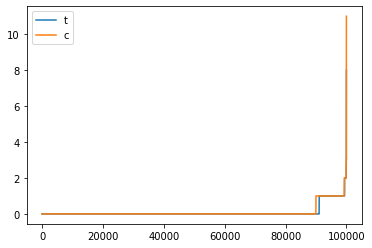

In [64]:
x = np.arange(100000)

t_sorted = treatment.sort_values()
c_sorted = control.sort_values()

t = [t_sorted.iloc[int(v * treatment.size / 100000)] for v in x]
c = [c_sorted.iloc[int(v * control.size / 100000)] for v in x]

plt.plot(x, t, x, c)
plt.legend(['t', 'c'])
plt.show()

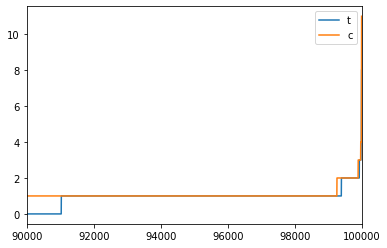

In [66]:
x = np.arange(100000)

t_sorted = treatment.sort_values()
c_sorted = control.sort_values()

t = [t_sorted.iloc[int(v * treatment.size / 100000)] for v in x]
c = [c_sorted.iloc[int(v * control.size / 100000)] for v in x]

plt.plot(x, t, x, c)
plt.legend(['t', 'c'])

plt.xlim(90000, 100000)
plt.show()

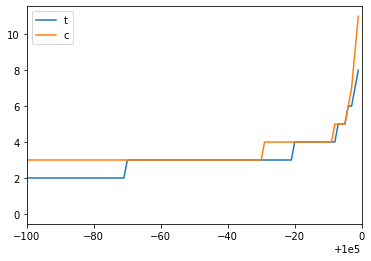

In [67]:
x = np.arange(100000)

t_sorted = treatment.sort_values()
c_sorted = control.sort_values()

t = [t_sorted.iloc[int(v * treatment.size / 100000)] for v in x]
c = [c_sorted.iloc[int(v * control.size / 100000)] for v in x]

plt.plot(x, t, x, c)
plt.legend(['t', 'c'])

plt.xlim(99900, 100000)
plt.show()

# Create new data to be more illustrative

In [103]:
t = treatment.sort_values().reset_index().sum_of_orders
t[:4743] = 1
t = t.sort_values().reset_index().sum_of_orders
t.mean()

0.10985926303612449

In [93]:
c = control.sort_values().reset_index().sum_of_orders
c.mean()

0.10934096042554897

In [94]:
t999 = t.quantile(.999)
c999 = c.quantile(.999)

In [95]:
tre_outlier_mean = t[t > t999].mean()
tre_outlier_mean

3.5193798449612403

In [96]:
ctr_outlier_mean = c[c > c999].mean()
ctr_outlier_mean

4.883928571428571

In [97]:
tre_filtered_mean = t[t <= t999].mean()
tre_filtered_mean

0.10744617815524393

In [98]:
ctr_filtered_mean = c[c <= c999].mean()
ctr_filtered_mean

0.10791111063576056

In [104]:
t.to_csv('treatment_orders.csv', index=False)
c.to_csv('control_orders.csv', index=False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
